In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

import typing

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
# os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign'
os.environ['PYTHONPATH'] += ':/content/gdrive/MyDrive/optimized_bio_sensor/RockleyCodesign'
# %cd /content/gdrive/MyDrive/22FL/CS101-TA/optimized_bio_sensor/RockleyCodesign
%cd /content/gdrive/MyDrive/optimized_bio_sensor/RockleyCodesign

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1EaHvULJYewcfEpQ7wlYgmG1eRbVcahUv/optimized_bio_sensor/RockleyCodesign


## Utility Functions

In [5]:
NUM_LASERS = 197


def _process_data(
    data: pd.DataFrame,
    standardize: bool
) -> typing.Tuple[np.array, np.array]:
    """
    Split data into lasers X and ethanol concentration y. Standardize the
    input data to have zero mean and one standard deviation if specified.
    """
    X = data.iloc[:, :NUM_LASERS].to_numpy(copy=True)
    y = data.iloc[:, NUM_LASERS].to_numpy(copy=True)

    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    return X, y

def _standardize_given(
    data: np.array,
    mean: np.array,
    std: np.array,
) -> np.array:
    norm = np.array(data)
    for i in range(len(mean)):
        norm[:, i] = (norm[:, i] - mean[i]) / std[i]
    return norm

def _split_data(
    X: np.array,
    y: np.array,
    split: float,
    seed: int
) -> typing.Tuple[typing.Tuple[np.array, np.array], typing.Tuple[np.array, np.array]]:
    """
    Split data into training and validation sets
    """
    np.random.seed(seed)
    indicies = np.random.permutation(X.shape[0])
    num_train = int(split * X.shape[0])
    train_indicies = indicies[:num_train]
    valid_indicies = indicies[num_train:]

    X_train = X[train_indicies, :]
    y_train = y[train_indicies]

    X_valid = X[valid_indicies, :]
    y_valid = y[valid_indicies]

    return (X_train, y_train), (X_valid, y_valid)


def load_data(
    filename: str,
    standardize: bool = True,
    split: float = 0.8,
    seed: int = 2022
) -> typing.Tuple[typing.Tuple[np.array, np.array], typing.Tuple[np.array, np.array]]:
    """
    Load data from a file and split into training/validation sets.

    Args:
        filename: name of the data file 
        split: percentage of data used for training (remainder used for validation)
        standardize: if true, input features are normalized to have zero mean
        and one standard deviation
        seed: random seed used for data splitting

    Returns:
        (X_train, y_train), (X_valid, y_valid)
    """
    # load data
    data = pd.read_parquet(filename)
    X, y = _process_data(data, standardize)

    return _split_data(X, y, split, seed)

def load_train_test_val(
    trainfile: str,
    testfile: str,
    standardize: bool,
    split: float = 0.8,
    seed: int = 2022,
    precision: int = 64,
    truncate: float = 1,
    standardize_y: bool = False,
    top_idx: int = -1,
    idx_file: str = "../data/removed_lasers.npy",
    noise: float = 0,
) -> typing.Tuple[typing.Tuple[np.array, np.array], typing.Tuple[np.array, np.array], typing.Tuple[np.array, np.array]]:
    train, val = load_data(filename=trainfile, standardize=False, split=split, seed=seed)
    test, _ = load_data(filename=testfile, standardize=False, split=1, seed=seed)

    Xtrain_un, Ytrain = train
    Xval_un, Yval = val
    Xtest_un, Ytest = test

    if top_idx > 0:
        idxs = np.load(idx_file)
        Xtrain_un = Xtrain_un[:, idxs[-top_idx:]]
        Xval_un = Xval_un[:, idxs[-top_idx:]]
        Xtest_un = Xtest_un[:, idxs[-top_idx:]]

    if noise > 0:
        Xtrain_un = Xtrain_un + np.random.normal(0, noise, np.shape(Xtrain_un))
        Xval_un = Xval_un + np.random.normal(0, noise, np.shape(Xval_un))
        Xtest_un = Xtest_un + np.random.normal(0, noise, np.shape(Xtest_un))

    if not standardize:
        if precision == 32:
            Xtrain_un = np.array(Xtrain_un, dtype=np.float32)
            Ytrain = np.array(Ytrain, dtype=np.float32)
            Xval_un = np.array(Xval_un, dtype=np.float32)
            Yval = np.array(Yval, dtype=np.float32)
            Xtest_un = np.array(Xtest_un, dtype=np.float32)
            Ytest = np.array(Ytest, dtype=np.float32)
        
        Xtrain_un = Xtrain_un[:int(truncate * len(Xtrain_un))]
        Ytrain = Ytrain[:int(truncate * len(Ytrain))]
        
        return (Xtrain_un, Ytrain), (Xval_un, Yval), (Xtest_un, Ytest)
    
    Xmean = np.mean(Xtrain_un, axis=0)
    Xstd = np.std(Xtrain_un, axis=0)
    Xtrain_n = _standardize_given(Xtrain_un, Xmean, Xstd)
    Xval_n = _standardize_given(Xval_un, Xmean, Xstd)
    Xtest_n = _standardize_given(Xtest_un, Xmean, Xstd)
    if standardize_y:
        Ymean = np.mean(Ytrain, axis=0)
        Ystd = np.std(Ytrain, axis=0)
        Ytrain = (Ytrain - Ymean) / Ystd
        Yval = (Yval - Ymean) / Ystd
        Ytest = (Ytest - Ymean) / Ystd

    if precision == 32:
        Xtrain_n = np.array(Xtrain_n, dtype=np.float32)
        Ytrain = np.array(Ytrain, dtype=np.float32)
        Xval_n = np.array(Xval_n, dtype=np.float32)
        Yval = np.array(Yval, dtype=np.float32)
        Xtest_n = np.array(Xtest_n, dtype=np.float32)
        Ytest = np.array(Ytest, dtype=np.float32)
    
    Xtrain_n = Xtrain_n[:int(truncate * len(Xtrain_n))]
    Ytrain = Ytrain[:int(truncate * len(Ytrain))]

    return (Xtrain_n, Ytrain), (Xval_n, Yval), (Xtest_n, Ytest)

## Feature Importance (Top K Linear Regression)

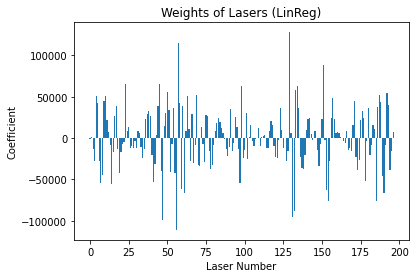

In [15]:
# Load data
train, val, test = load_train_test_val(
    trainfile="../data/train_regression.parquet",
    testfile="../data/test_regression.parquet",
    standardize=True,
    precision=32,
)

Xtrain, Ytrain = train
Xval, Yval = val
Xtest, Ytest = test

# Train linear regression model
model = LinearRegression()

model.fit(Xtrain, Ytrain)
importance = model.coef_

# Plot coefficients of weights
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xlabel("Laser Number")
pyplot.ylabel("Coefficient")
pyplot.title("Weights of Lasers (LinReg)")
pyplot.show()

In [16]:
# Dictionary of absolute value of weights -> laser number
feature_scores = {}
for feature, score in enumerate(importance):
  feature_scores[abs(score)] = feature

# Sort weights in descending order
importance = np.sort(list(feature_scores.keys()))
importance = importance[::-1]

In [17]:
def get_mse(X_train, Y_train, X_test, Y_test, model, **kwargs):
  model_ = model(**kwargs)
  model_.fit(X_train, Y_train)
  Y_pred = model_.predict(X_test)
  m = mean_squared_error(Y_test, Y_pred)

  return m

def get_top_k_lasers(X_train, Y_train, X_test, Y_test, model, feature_scores, weights, k):
  top_lasers = []

  # Lasers chosen by top weights
  for i in range(k):
    score = weights[i]
    top_lasers.append(feature_scores[score])

  X_top = X_train[:, top_lasers]
  X_test = X_test[:, top_lasers]
  mse = get_mse(X_top, Y_train, X_test, Y_test, model)
  top_lasers = [x+1 for x in top_lasers]
  return top_lasers, mse

In [ ]:
# Top 50 lasers
lasers, mse = get_top_k_lasers(Xtrain, Ytrain, Xtest, Ytest, sklearn.linear_model.LinearRegression, feature_scores, importance, 50)
print(f"Top 50 lasers: {lasers}")
print(f"MSE: {mse}")

In [14]:
# Top k (from 20 - 70) lasers chosen, MSE is calculated for each
all_mse = []
max_nmbr = 71
min_nmbr = 20
nmbr_lasers = list(range(min_nmbr, max_nmbr, 10))
for n in nmbr_lasers:
  _, mse = get_top_k_lasers(Xtrain, Ytrain, Xval, Yval, sklearn.linear_model.LinearRegression, feature_scores, importance, n)
  all_mse.append(mse)

for i in range(len(nmbr_lasers)):
  print(f"Laser {nmbr_lasers[i]}: {all_mse[i]}")

Laser 20: 16.97711753845215
Laser 30: 7.722635746002197
Laser 40: 8.625450134277344
Laser 50: 4.562143325805664
Laser 60: 5.606276512145996
Laser 70: 4.844027519226074


In [18]:
# Top k (from 10-170) lasers chosen, MSE is calculated for each
all_mse = []
max_nmbr = 171
min_nmbr = 10
nmbr_lasers = list(range(min_nmbr, max_nmbr))
for n in nmbr_lasers:
  _, mse = get_top_k_lasers(Xtrain, Ytrain, Xval, Yval, sklearn.linear_model.LinearRegression, feature_scores, importance, n)
  all_mse.append(mse)
  print(f"Laser {n}: {mse}")

Laser 10: 2513.37109375
Laser 11: 1890.375244140625
Laser 12: 1175.6490478515625
Laser 13: 1123.1180419921875
Laser 14: 872.2772216796875
Laser 15: 871.96142578125
Laser 16: 328.9781799316406
Laser 17: 132.88690185546875
Laser 18: 106.33013916015625
Laser 19: 23.6195125579834
Laser 20: 16.97711753845215
Laser 21: 16.515865325927734
Laser 22: 11.701765060424805
Laser 23: 11.595558166503906
Laser 24: 9.557279586791992
Laser 25: 8.002445220947266
Laser 26: 7.685306549072266
Laser 27: 8.500480651855469
Laser 28: 14.647980690002441
Laser 29: 13.544708251953125
Laser 30: 7.722635746002197
Laser 31: 10.157753944396973
Laser 32: 6.655250072479248
Laser 33: 8.587701797485352
Laser 34: 19.44166374206543
Laser 35: 8.80517864227295
Laser 36: 12.002427101135254
Laser 37: 23.48586654663086
Laser 38: 27.520755767822266
Laser 39: 13.298158645629883
Laser 40: 8.625450134277344
Laser 41: 7.350811958312988
Laser 42: 29.77600860595703
Laser 43: 24.06574249267578
Laser 44: 9.94017219543457
Laser 45: 9.5838

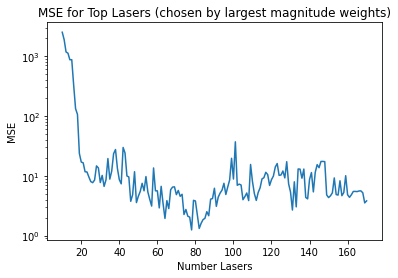

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log')
plt.plot(nmbr_lasers, all_mse)
plt.xlabel("Number Lasers")
plt.ylabel("MSE")
plt.title("MSE for Top Lasers (chosen by largest magnitude weights)")
plt.show()

## Feature Selection

In [ ]:
import seaborn as sns

In [ ]:
df = pd.read_parquet("../data/train_regression.parquet")

# Rename Columns
new_col = {}
for col in list(df.columns):
  if col == "eEthanol":
    continue
  new_col[col] = col[len("Laser")+1:]

df.rename(columns=new_col, inplace=True, errors='raise')

In [ ]:
# Using Pearson Correlation
cor = df.corr()

plt.figure(figsize=(30,25))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

cor_mag = abs(cor["eEthanol"])
cor['eEthanol'] = cor_mag

In [ ]:
train, val, test = load_train_test_val(
    trainfile="../data/train_regression.parquet",
    testfile="../data/test_regression.parquet",
    standardize=True,
    precision=64,
)

X_train, Y_train = train
X_val, Y_val = val

all_cor_mse = []

max_nmbr = 150
nmbr_lasers = list(range(15, max_nmbr))

for i in range(15, max_nmbr):
  largest_cor = cor.nlargest(i, 'eEthanol')
  index = list(largest_cor.index)
  index.pop(0)
  top_lasers = [int(i) - 1 for i in index]

  X_top = X_train[:, top_lasers]
  X_top_val = X_val[:, top_lasers]
  cor_mse = get_mse(X_top, Y_train, X_top_val, Y_val, sklearn.linear_model.LinearRegression)

  all_cor_mse.append(cor_mse)

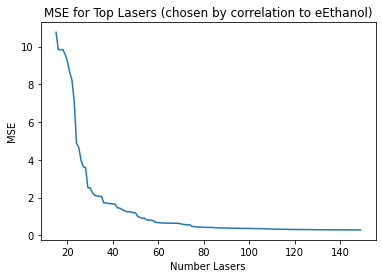

In [ ]:
nmbr_lasers = list(range(15, max_nmbr))
plt.plot(nmbr_lasers, all_cor_mse)
plt.xlabel("Number Lasers")
plt.ylabel("MSE")
plt.title("MSE for Top Lasers (chosen by correlation to eEthanol)")
plt.show()

In [ ]:
for i in range(len(all_cor_mse)):
  print(f"Lasers: {i+15}, MSE: {all_cor_mse[i]}")

Lasers: 15, MSE: 10.76084305407686
Lasers: 16, MSE: 9.84273287584826
Lasers: 17, MSE: 9.83889293492754
Lasers: 18, MSE: 9.838810814417577
Lasers: 19, MSE: 9.593408654352416
Lasers: 20, MSE: 9.216834344639071
Lasers: 21, MSE: 8.646847575336123
Lasers: 22, MSE: 8.231664465323968
Lasers: 23, MSE: 7.101114512346699
Lasers: 24, MSE: 4.8853010261377126
Lasers: 25, MSE: 4.654875243502294
Lasers: 26, MSE: 3.9851194065281117
Lasers: 27, MSE: 3.625354289349033
Lasers: 28, MSE: 3.5852205691149845
Lasers: 29, MSE: 2.5260296536868547
Lasers: 30, MSE: 2.5225735206745603
Lasers: 31, MSE: 2.2689789581511173
Lasers: 32, MSE: 2.1160071855058136
Lasers: 33, MSE: 2.07868478317842
Lasers: 34, MSE: 2.0694210328681795
Lasers: 35, MSE: 2.0684648773957792
Lasers: 36, MSE: 1.7233382503857815
Lasers: 37, MSE: 1.7233610973901505
Lasers: 38, MSE: 1.6833749503443312
Lasers: 39, MSE: 1.6805138402493807
Lasers: 40, MSE: 1.6615432235638141
Lasers: 41, MSE: 1.661519340981346
Lasers: 42, MSE: 1.4590972171045287
Lasers: 